# Why use polars ?


Polars is a DataFrame library written in Rust. It's designed to be extremely fast and efficient, especially when working with large datasets. Here's a breakdown of why you might choose Polars for both small and large datasets:

**Speed and Efficiency:**

* **Small Datasets:** Polars' optimized execution and minimal overhead can still provide noticeable speed improvements over Pandas, even on smaller datasets. This can be beneficial for iterative development and quick analysis tasks.
* **Large Datasets:** Polars truly shines when dealing with large datasets. Its columnar memory layout, query optimization, and parallel processing capabilities allow it to outperform Pandas significantly in terms of speed and memory usage.

**When Your Principal Utility Lies:**

* **Performance-critical applications:** If you're working on applications where performance is critical, Polars is a great choice.
* **Large datasets:** If you're working with datasets that are too large to fit into memory or that are slow to process with Pandas, Polars can provide a significant improvement.
* **ETL pipelines:** Polars can be used to build efficient ETL pipelines that can process large amounts of data quickly.
* **Data analysis and exploration:** Polars can be used for interactive data analysis and exploration, even on large datasets.

**Key Advantages:**

* **Lazy Evaluation:** Polars uses lazy evaluation, which means that operations are not executed until necessary. This allows Polars to optimize the query plan and minimize the amount of computation required.
* **Parallelism:** Polars is designed to take advantage of multiple CPU cores, which can significantly speed up processing times, especially for large datasets.
* **Memory Efficiency:** Polars' columnar memory layout and efficient data structures allow it to use memory more efficiently than Pandas. This is particularly important when working with large datasets that may not fit into memory.
* **Expressive API:** Polars has an API that is similar to Pandas, making it relatively easy to learn and use.
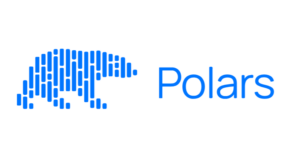
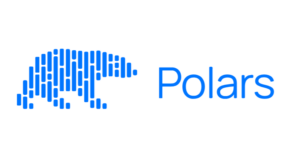

# Competition: 

### https://www.kaggle.com/competitions/playground-series-s4e12/overview

This Kaggle Playground Series competition focuses on predicting insurance premiums. 

*   **Objective:** Predict `Premium Amount` (a continuous target) based on provided features.
*   **Evaluation Metric:** Root Mean Squared Logarithmic Error (RMSLE). This metric penalizes under-predictions more heavily than over-predictions and is often used when the target variable has a skewed distribution.
*   **Data:** Synthetically generated data based on a deep learning model trained on a real insurance premium dataset. Participants are allowed to use the original dataset for exploration and potential model improvement. The data is provided in `train.csv` and `test.csv`, with a `sample_submission.csv` demonstrating the required submission format (`id`, `Premium Amount`).
*   **Timeline:** The competition runs through December 2024, with a final submission deadline of December 31, 2024.
*   **Prizes:** Kaggle merchandise for the top three places (with a limit of one win per person in the series to encourage beginner participation).
*   **Tabular Playground Series Goal:** Provide accessible challenges for practicing machine learning skills using lightweight, often synthetic datasets. This allows for rapid experimentation with models and feature engineering.
*   **Synthetic Data Rationale:** Synthetic data balances realism (feature names) with preventing test label leakage, enabling more interesting datasets for competitions.
*   **Key Files:**
    *   `train.csv`: Training data with the `Premium Amount` target.
    *   `test.csv`: Test data for prediction.
    *   `sample_submission.csv`: Example of the correct submission format.


In [16]:
%%capture
pip install --upgrade pandas polars scikit-learn xgboost lightgbm

# SETUP

In [17]:
import os
import warnings
from pathlib import Path
import polars as pl

# Data handling and processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models and utilities
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_log_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeRegressor

# Statsmodels
import statsmodels.api as sm

# Configure plotting styles
plt.style.use("seaborn-darkgrid")
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


<ipython-input-17-7e5c60436d14>:35: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


# EDA 

----

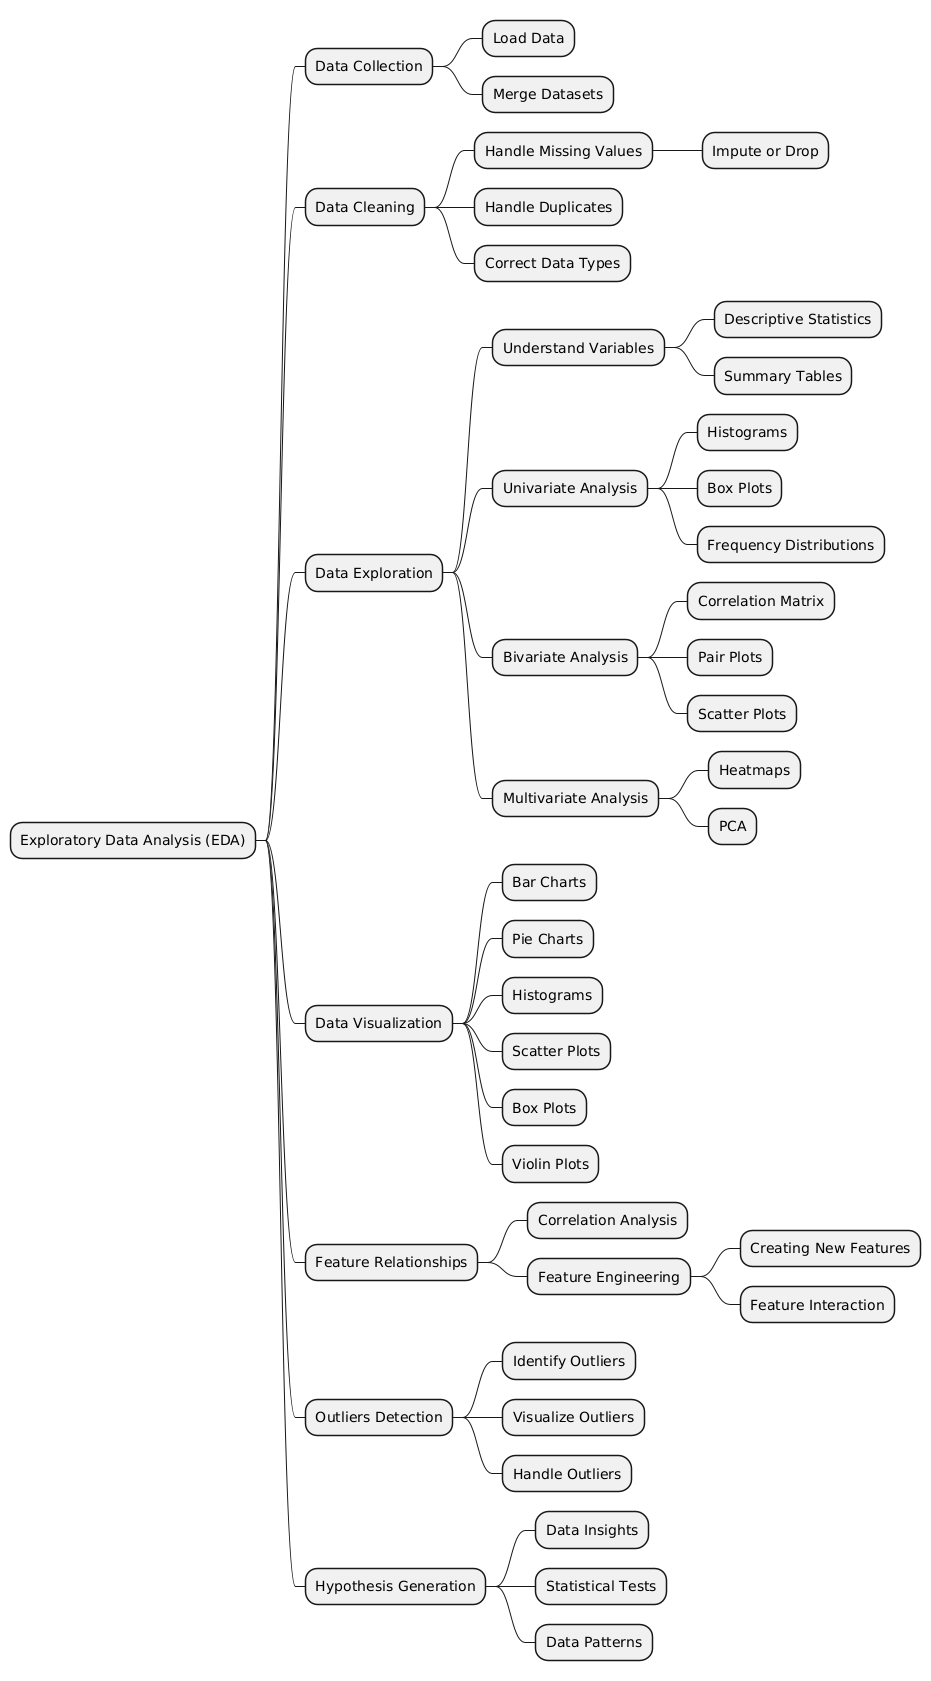

being (n) the cardinality

**Potential relationships between the "insurance premium" and categorical variables (cat_cols):**

*   **Gender (2):** There is likely to be a difference in premium based on gender, although not necessarily a direct correlation. There could be differences based on gender-based risk statistics.
*   **Marital Status (4):** Marital status could influence the premium. For example, married people might have access to family policies with different prices.
*   **Education Level (4):** Education level could be correlated with the type of job and, therefore, with the level of risk and the premium.
*   **Occupation (4):** Occupation is an important factor. Some occupations are inherently riskier than others (e.g., construction jobs vs. office jobs), which would be reflected in the premium.
*   **Location (3):** Geographic location is a key factor. Areas with higher rates of crime, accidents, or natural disasters usually have higher premiums.
*   **Policy Type (3):** The type of policy (e.g., basic, comprehensive, with additional coverage) will have a direct impact on the premium.
*   **Customer Feedback (4):** Customer feedback could be related to satisfaction with the service and, although less directly with the premium, could influence policy renewal and, therefore, long-term revenue.
*   **Smoking Status (2):** Smoking is a major health risk factor and, therefore, usually influences health and life insurance premiums.
*   **Exercise Frequency (4):** Exercise frequency could be related to a lower health risk, which could translate into a lower premium, especially in health insurance.
*   **Property Type (3):** The type of property insured (e.g., house, apartment, commercial premises) will significantly affect the property insurance premium.

**Potential relationships between the "insurance premium" and numerical variables (NumCOls):**

*   **Age (48):** Age is usually related to risk. For example, young drivers and older adults may have higher premiums in auto insurance. In health insurance, older age usually implies higher costs.
*   **Annual Income (88594):** Annual income could be related to affordability and, therefore, to the choice of broader coverage and higher premiums.
*   **Number of Dependents (6):** The number of dependents could influence the need for greater coverage and, therefore, the premium, especially in health and life insurance.
*   **Health Score (532659):** A lower health score will likely correlate with a higher premium in health insurance. The high cardinality suggests a very granular measure of health.
*   **Previous Claims (11):** The history of previous claims is a strong predictor of future claims and, therefore, directly influences the premium.
*   **Vehicle Age (21):** The age of the vehicle can influence the auto insurance premium. Newer vehicles are usually more expensive to repair or replace, but they may also have better safety features.
*   **Credit Score (551):** A good credit history is often associated with lower risk and, therefore, with lower premiums in some types of insurance.
*   **Insurance Duration (10):** The duration of the insurance could be related to loyalty discounts or to changes in risk over time.


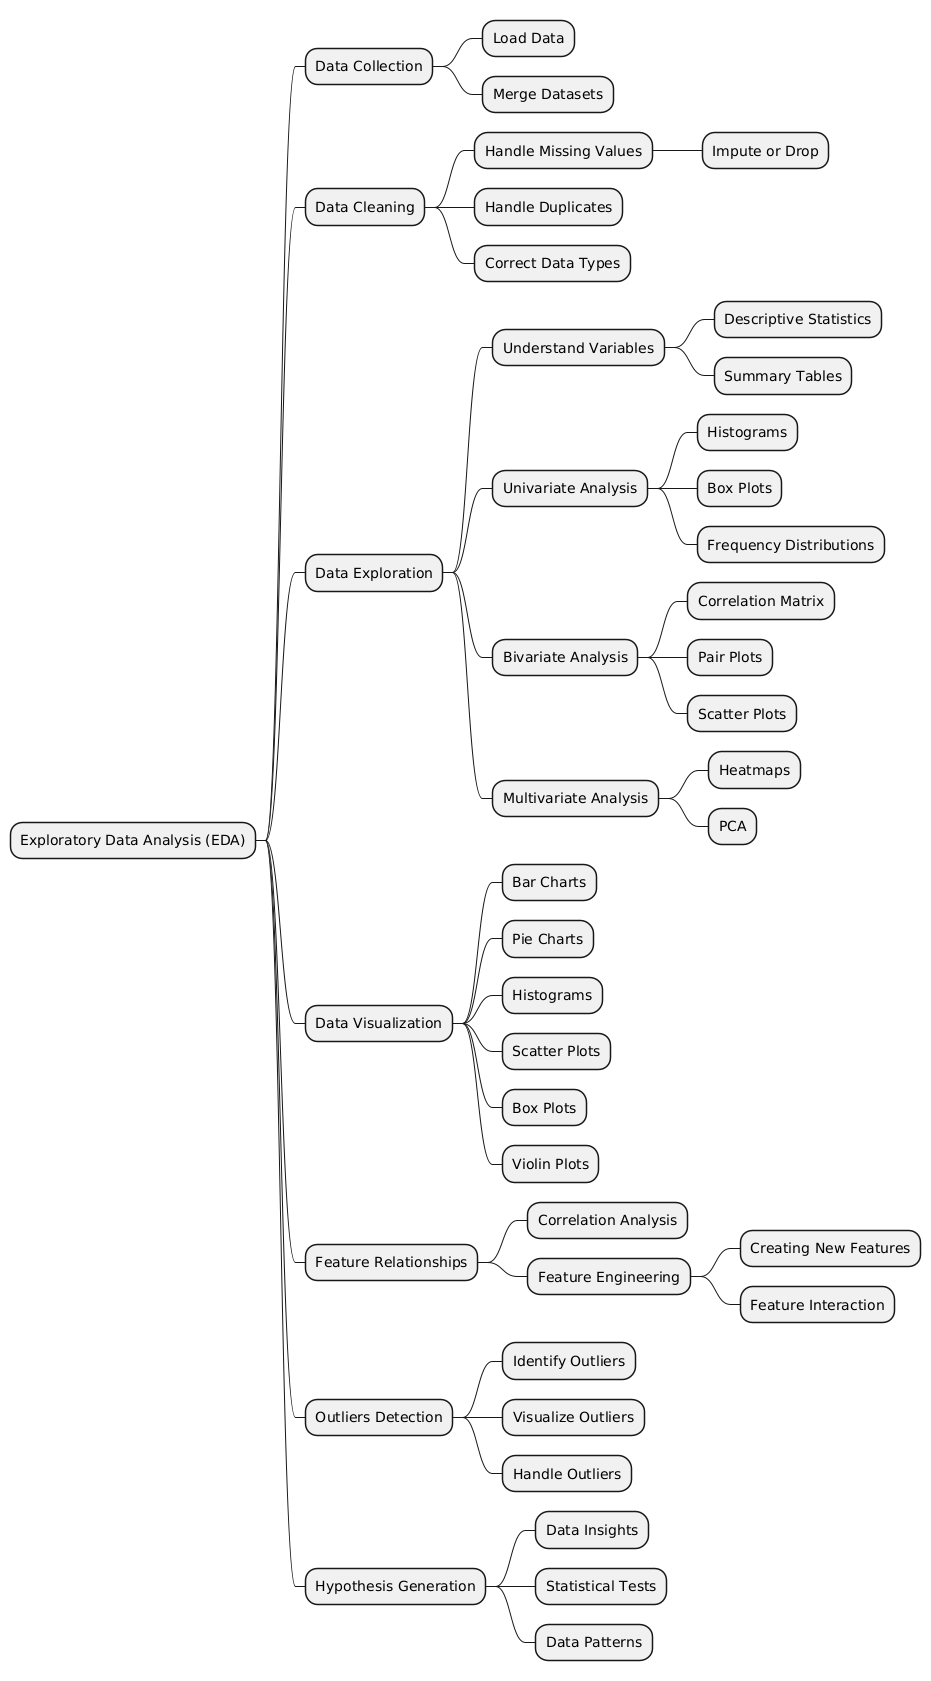

# 1) Data Collection

## 1.1) Load Data

In [18]:

train = pl.read_csv("/kaggle/input/playground-series-s4e12/train.csv")
test = pl.read_csv("/kaggle/input/playground-series-s4e12/test.csv")
test_id = test["id"].to_numpy()
y = train["Premium Amount"]
train = train.drop(["Policy Start Date", "id"])
X = train.drop(["Premium Amount"])
test = test.drop(["Policy Start Date", "id"])

num_cols = [col for col in train.columns if train[col].dtype == pl.Float64 or train[col].dtype == pl.Int64]
cat_cols = [col for col in train.columns if train[col].dtype == pl.String]

print("\n\ntrain Tail: ")
display(train.tail())
print("\n\ntest Tail: ")
display(test.tail())
print("\n\nDescribe: ")
display(train.describe())



train Tail: 


Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
f64,str,f64,str,f64,str,str,f64,str,str,f64,f64,f64,f64,str,str,str,str,f64
36.0,"""Female""",27316.0,"""Married""",0.0,"""Master's""","""Unemployed""",13.772907,"""Urban""","""Premium""",null,5.0,372.0,3.0,"""Poor""","""No""","""Daily""","""Apartment""",1303.0
54.0,"""Male""",35786.0,"""Divorced""",null,"""Master's""","""Self-Employed""",11.483482,"""Rural""","""Comprehensive""",null,10.0,597.0,4.0,"""Poor""","""No""","""Weekly""","""Apartment""",821.0
19.0,"""Male""",51884.0,"""Divorced""",0.0,"""Master's""",null,14.724469,"""Suburban""","""Basic""",0.0,19.0,null,6.0,"""Good""","""No""","""Monthly""","""Condo""",371.0
55.0,"""Male""",null,"""Single""",1.0,"""PhD""",null,18.547381,"""Suburban""","""Premium""",1.0,7.0,407.0,4.0,"""Poor""","""No""","""Daily""","""Apartment""",596.0
21.0,"""Female""",null,"""Divorced""",0.0,"""PhD""",null,10.125323,"""Rural""","""Premium""",0.0,18.0,502.0,6.0,"""Good""","""Yes""","""Monthly""","""House""",2480.0




test Tail: 


Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
f64,str,f64,str,f64,str,str,f64,str,str,f64,f64,f64,f64,str,str,str,str
50.0,"""Female""",38782.0,"""Married""",1.0,"""Bachelor's""",null,14.498639,"""Rural""","""Premium""",null,8.0,309.0,2.0,"""Average""","""Yes""","""Daily""","""Condo"""
null,"""Female""",73462.0,"""Single""",0.0,"""Master's""",null,8.145748,"""Rural""","""Basic""",2.0,0.0,null,2.0,"""Good""","""No""","""Daily""","""Apartment"""
26.0,"""Female""",35178.0,"""Single""",0.0,"""Master's""","""Employed""",6.636583,"""Urban""","""Comprehensive""",null,10.0,null,6.0,"""Poor""","""No""","""Monthly""","""Apartment"""
34.0,"""Female""",45661.0,"""Single""",3.0,"""Master's""",null,15.937248,"""Urban""","""Premium""",2.0,17.0,467.0,7.0,"""Average""","""No""","""Weekly""","""Condo"""
25.0,"""Male""",24843.0,"""Divorced""",3.0,"""High School""",null,24.893939,"""Suburban""","""Comprehensive""",null,15.0,null,8.0,"""Good""","""No""","""Rarely""","""House"""




Describe: 


statistic,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
str,f64,str,f64,str,f64,str,str,f64,str,str,f64,f64,f64,f64,str,str,str,str,f64
"""count""",1.181295e6,"""1200000""",1.155051e6,"""1181471""",1.090328e6,"""1200000""","""841925""",1.125924e6,"""1200000""","""1200000""",835971.0,1.199994e6,1.062118e6,1.199999e6,"""1122176""","""1200000""","""1200000""","""1200000""",1.2e6
"""null_count""",18705.0,"""0""",44949.0,"""18529""",109672.0,"""0""","""358075""",74076.0,"""0""","""0""",364029.0,6.0,137882.0,1.0,"""77824""","""0""","""0""","""0""",0.0
"""mean""",41.145563,null,32745.217777,null,2.009934,null,null,25.613908,null,null,1.002689,9.569889,592.92435,5.018219,null,null,null,null,1102.544822
"""std""",13.53995,null,32179.506124,null,1.417338,null,null,12.203462,null,null,0.98284,5.776189,149.981945,2.594331,null,null,null,null,864.998859
"""min""",18.0,"""Female""",1.0,"""Divorced""",0.0,"""Bachelor's""","""Employed""",2.012237,"""Rural""","""Basic""",0.0,0.0,300.0,1.0,"""Average""","""No""","""Daily""","""Apartment""",20.0
"""25%""",30.0,null,8001.0,null,1.0,null,null,15.918959,null,null,0.0,5.0,468.0,3.0,null,null,null,null,514.0
"""50%""",41.0,null,23911.0,null,2.0,null,null,24.578716,null,null,1.0,10.0,595.0,5.0,null,null,null,null,872.0
"""75%""",53.0,null,44634.0,null,3.0,null,null,34.527209,null,null,2.0,15.0,721.0,7.0,null,null,null,null,1509.0
"""max""",64.0,"""Male""",149997.0,"""Single""",4.0,"""PhD""","""Unemployed""",58.975914,"""Urban""","""Premium""",9.0,19.0,849.0,9.0,"""Poor""","""Yes""","""Weekly""","""House""",4999.0


## 1.2) Merge Datasets

In [19]:
train_size = train.shape[0]

full = pl.concat(
    [
        X,
        test,
    ],
    how="vertical",
)
print(full)

shape: (2_000_000, 18)
┌──────┬────────┬─────────────┬─────────────┬───┬─────────────┬─────────┬─────────────┬────────────┐
│ Age  ┆ Gender ┆ Annual      ┆ Marital     ┆ … ┆ Customer    ┆ Smoking ┆ Exercise    ┆ Property   │
│ ---  ┆ ---    ┆ Income      ┆ Status      ┆   ┆ Feedback    ┆ Status  ┆ Frequency   ┆ Type       │
│ f64  ┆ str    ┆ ---         ┆ ---         ┆   ┆ ---         ┆ ---     ┆ ---         ┆ ---        │
│      ┆        ┆ f64         ┆ str         ┆   ┆ str         ┆ str     ┆ str         ┆ str        │
╞══════╪════════╪═════════════╪═════════════╪═══╪═════════════╪═════════╪═════════════╪════════════╡
│ 19.0 ┆ Female ┆ 10049.0     ┆ Married     ┆ … ┆ Poor        ┆ No      ┆ Weekly      ┆ House      │
│ 39.0 ┆ Female ┆ 31678.0     ┆ Divorced    ┆ … ┆ Average     ┆ Yes     ┆ Monthly     ┆ House      │
│ 23.0 ┆ Male   ┆ 25602.0     ┆ Divorced    ┆ … ┆ Good        ┆ Yes     ┆ Weekly      ┆ House      │
│ 21.0 ┆ Male   ┆ 141855.0    ┆ Married     ┆ … ┆ Poor        ┆ Yes 

# 2) Exploring Missing and Duplicates

## 2.1) Duplicates

In [20]:
train.is_duplicated().sum()

2

## 2.2) Cardinality

In [21]:
print("Cardinality cat_cols: \n")
for c in cat_cols:
    print(c, ": ", train[c].n_unique())

print("\n\n\n Cardinality NumCOls\n")
for n in num_cols:
    print(n, ": ", train[n].n_unique())

Cardinality cat_cols: 

Gender :  2
Marital Status :  4
Education Level :  4
Occupation :  4
Location :  3
Policy Type :  3
Customer Feedback :  4
Smoking Status :  2
Exercise Frequency :  4
Property Type :  3



 Cardinality NumCOls

Age :  48
Annual Income :  88594
Number of Dependents :  6
Health Score :  532659
Previous Claims :  11
Vehicle Age :  21
Credit Score :  551
Insurance Duration :  10
Premium Amount :  4794


## 2.3) Missing

In [22]:
print("\n\n TRAIN Missing/null_count: ")
display(train.null_count())

print("\n\nFULL Missing/null_count: ")
display(full.null_count())



 TRAIN Missing/null_count: 


Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
18705,0,44949,18529,109672,0,358075,74076,0,0,364029,6,137882,1,77824,0,0,0,0




FULL Missing/null_count: 


Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
31194,0,74809,30865,182802,0,597200,123525,0,0,606831,9,229333,3,130100,0,0,0


# 3) Data Exploration and Visualization

## 3.1) Continuos and Discrete Variables

In [93]:
# import polars as pl
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np


# def univariate_exploration(df, num_cols, sample_size=9000, n_cols=2):
#     """
#     Function for univariate exploration using histograms for numerical columns.
#     Displays the histograms in multiple columns per row.
#     """
  
#     sample_df = df.sample(n=sample_size)

  
#     n_rows = (len(num_cols) + n_cols - 1) // n_cols

#     plt.figure(figsize=(10, 6 * n_rows))
#     for i, col in enumerate(num_cols):
#         plt.subplot(n_rows, n_cols, i + 1)  # Definir la posición del subgráfico
#         sns.histplot(sample_df[col], kde=True, bins=30, color='skyblue')
#         plt.title(f"Histogram of {col}")
#         plt.xlabel(col)
#         plt.ylabel("Frequency")

#     plt.tight_layout()
#     plt.show()


# def bivariate_exploration(df, col1, col2, sample_size=9000, n_cols=1):
#     """
#     Function for bivariate exploration using regplot (linear relationship) and scatterplot.
#     Displays the plots in multiple columns per row.
#     """
    
#     sample_df = df.sample(n=sample_size)

    
#     n_rows = 2 

#     plt.figure(figsize=(10, 6 * n_rows))

   
#     plt.subplot(n_rows, n_cols, 1)
#     sns.regplot(x=col1, y=col2, data=sample_df, scatter_kws={'s': 10}, line_kws={'color': 'red'})
#     plt.title(f"Regplot of {col1} vs {col2}")
#     plt.xlabel(col1)
#     plt.ylabel(col2)

#     plt.tight_layout()
#     plt.show()


# def multivariate_exploration(df, num_cols, sample_size=9000, n_cols=2):
#     """
#     Function for multivariate exploration using Pearson correlation matrix.
#     Displays the correlation heatmap in multiple columns per row.
#     """
#     # Crear una muestra aleatoria sin reemplazo
#     sample_df = df.sample(n=sample_size)

#     # Correlación de Pearson
#     pearson_corr = sample_df.select(num_cols).to_pandas().corr()

#     plt.figure(figsize=(10, 8))
#     plt.subplot(1, 1, 1)  # Solo un gráfico de correlación
#     sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
#     plt.title("Pearson Correlation Matrix")
#     plt.show()


# # Llamar a las funciones de exploración
# univariate_exploration(train, num_cols, n_cols=2) # 
# bivariate_exploration(train, "Health Score", "Premium Amount", n_cols=1)
# bivariate_exploration(train, "Credit Score", "Premium Amount", n_cols=1)
# multivariate_exploration(train, num_cols, n_cols=1)


## 3.2) Categorical Variables

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns


def categorical_target_violin_plot(df, cat_columns, target_column, sample_size=9000, n_cols=2):
    """
    Function to visualize categorical features in relation to the target variable using violin plots.
    
    - df: DataFrame de pandas
    - cat_columns: Lista de nombres de columnas categóricas
    - target_column: Columna objetivo (numérica)
    - n_cols: Número de columnas para los subgráficos (por defecto 2)
    """
    
    sample_df = df.sample(n=sample_size)

    
    sample_df_pd = sample_df.to_pandas()

  
    n_rows = (len(cat_columns) + n_cols - 1) // n_cols

    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6 * n_rows))
    axes = axes.flatten()  
   
    for i, col in enumerate(cat_columns):
        ax = axes[i]

       
        sns.violinplot(x=col, y=target_column, data=sample_df_pd, palette='Set2', ax=ax)
        ax.set_title(f"Violin Plot of {target_column} by {col}")
        ax.set_xlabel(col)
        ax.set_ylabel(target_column)

    plt.tight_layout()
    plt.show()

# categorical_target_violin_plot(train, cat_cols, "Credit Score")


# 4) Naive baseline

### Explanation:
- **`target_column`**: The column in your Polars DataFrame that holds the target variable.
- **`method`**: This parameter allows you to choose whether to use the mean or the median of the target values as the naive baseline prediction.
- **Naive prediction**: The function computes a constant prediction for all data points, which is either the mean or the median of the target variable.
- **RMSE calculation**: The function calculates the RMSE (Root Mean Squared Error) by comparing the naive predictions to the actual target values using `mean_squared_error` from Scikit-learn.


In [25]:
def naive_baseline_regression(data: pl.DataFrame, target_column: str, method='mean'):
    """
    Function to calculate the naive baseline for regression using Polars and Scikit-learn.
    
    Parameters:
    - data (pl.DataFrame): The Polars DataFrame containing the dataset.
    - target_column (str): The column name of the target variable.
    - method (str): Method to calculate the constant prediction ('mean' or 'median'). Default is 'mean'.
    
    Returns:
    - rmse (float): The RMSE of the naive baseline model.
    """
    
    # Get the target values from the dataframe
    target_values = data[target_column].to_numpy()

    # Choose between mean or median for the naive prediction
    if method == 'mean':
        naive_prediction = np.mean(target_values)
    elif method == 'median':
        naive_prediction = np.median(target_values)
    else:
        raise ValueError("Method must be 'mean' or 'median'")
    
    # Create the naive predictions array (constant prediction for all data points)
    naive_predictions = np.full_like(target_values, naive_prediction)
    
    # Calculate the RMSE using scikit-learn
    rmse = np.sqrt(mean_squared_log_error(target_values, naive_predictions))
    
    return rmse

# Call the function with 'mean' method (default)
rmse_mean = naive_baseline_regression(train, target_column='Premium Amount', method='mean')
print(f"RMSLE using mean: {rmse_mean}")

# Call the function with 'median' method
rmse_median = naive_baseline_regression(train, target_column='Premium Amount', method='median')
print(f"RMSLE using median: {rmse_median}")


RMSLE using mean: 1.1708541893745936
RMSLE using median: 1.1101942959324897


# 5) Selecting Pipeline

----

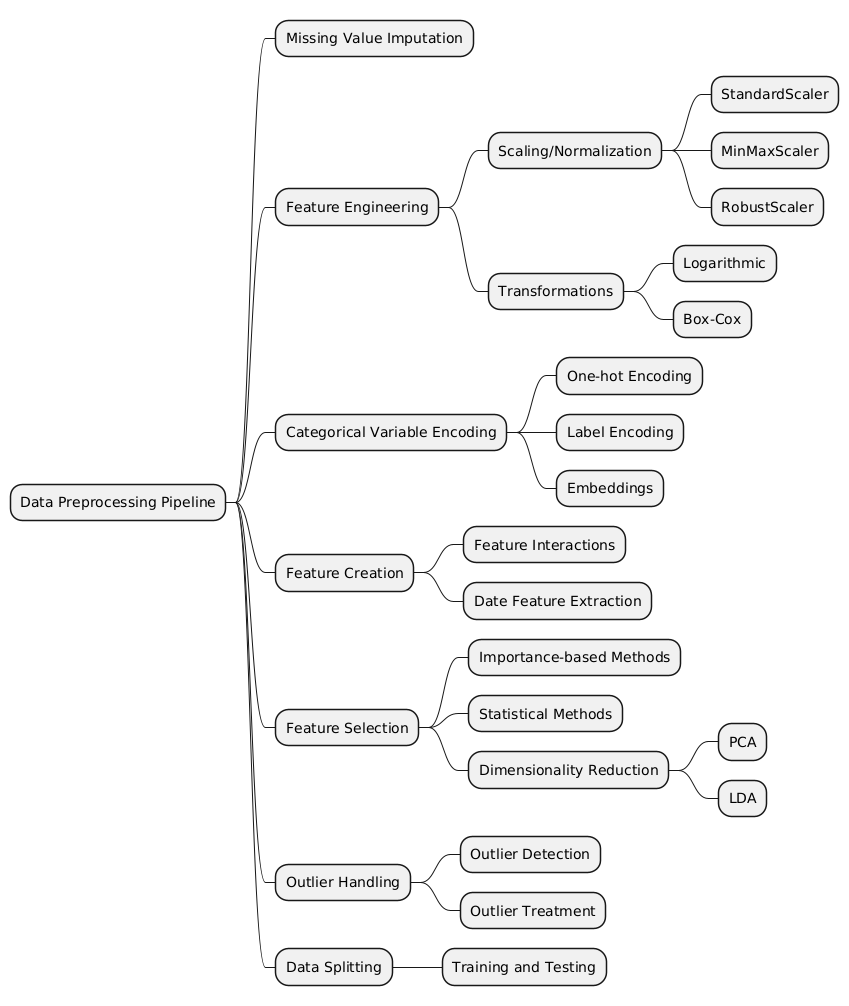
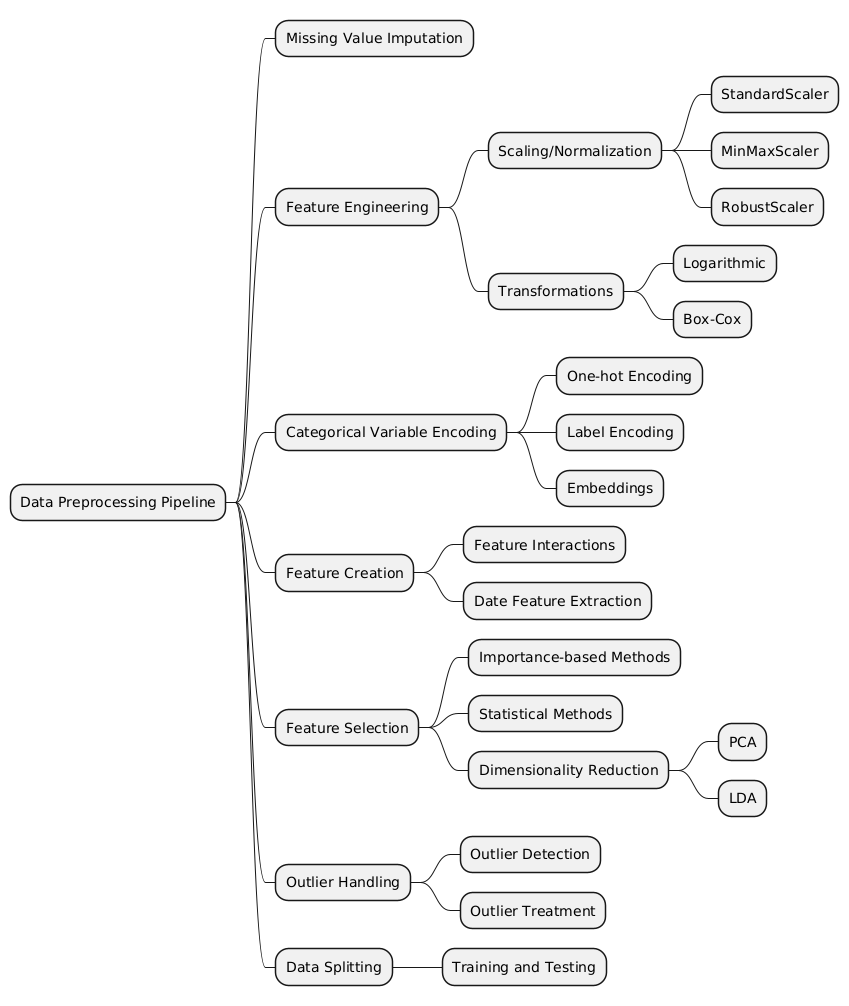

In [26]:
%%time
from sklearn.linear_model import LinearRegression

def base_score(x,y,pipeline):
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    
    # Fit the pipeline on the training data
    pipeline.fit(x_train, y_train)
    
    # Predict using the test set
    predictions = pipeline.predict(x_test)
    
    # Output predictions
    print(predictions)
    
    # Calcular el RMSLE
    msle = mean_squared_log_error(y_test, predictions)
    rmsle = np.sqrt(msle)
    
    print(f"naive_RMSLE using mean: {rmse_mean}")
    print(f"naive_RMSLE using median: {rmse_median}")
    print(f"this baseline_RMSLE: {rmsle}")

# base_score(x,y,pipeline)


CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 18.6 µs


In [27]:
# %%time 
# from sklearn.preprocessing import KBinsDiscretizer
# num_cols = [col for col in X.columns if X[col].dtype == pl.Float64 or X[col].dtype == pl.Int64]
# cat_cols = [col for col in X.columns if X[col].dtype == pl.String]

# # - Numerical: Imputation and scaling
# num_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median')),  # Impute missing values
#     # ('scaler', StandardScaler())                 # Scale data
#     ('Discretizar', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform'))
# ])

# # - Categorical: Imputation and one-hot encoding
# cat_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute with mode
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))     # One-hot encoding
#     # ('Ord Encoder', OrdinalEncoder())
# ])

# # Combine transformers in a ColumnTransformer
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', num_transformer, num_cols),  # Apply num_transformer to numerical columns
#         ('cat', cat_transformer, cat_cols)  # Apply cat_transformer to categorical columns
#     ]
# )

# models = [LinearRegression(), DecisionTreeRegressor(random_state=0)]

# for model in models:
#     # Create the complete pipeline with preprocessing and model
#     pipeline = Pipeline([
#         ('preprocessor', preprocessor),  # Preprocessing step
#         ('model', model)                 # Regression model
#     ])

#     print("model: ", model)
#     base_score(X,y,pipeline)
#     print("-------\n\n")

In [28]:
import polars as pl

def impute_data(df, column, method="mean", value=None):
    """
    Imputes missing values in a specific column of a Polars DataFrame
    using different methods like 'mean', 'median', 'constant', or 'mode'.
    
    Parameters:
    - df: Polars DataFrame.
    - column: name of the column to impute.
    - method: imputation method ('mean', 'median', 'constant', 'mode'). 
              If 'constant' is chosen, the 'value' parameter must be provided.
    - value: constant value for imputation if the method is 'constant'.
    
    Returns:
    - DataFrame with imputed values.
    """
    
    if method == "mean":
        # Impute with the mean of the column
        return df.with_columns(
            pl.col(column).fill_null(pl.col(column).mean())
        )
    
    elif method == "median":
        # Impute with the median of the column
        return df.with_columns(
            pl.col(column).fill_null(pl.col(column).median())
        )
    
    elif method == "constant":
        if value is None:
            raise ValueError("A constant value must be provided for imputation.")
        # Impute with a constant value
        return df.with_columns(
            pl.col(column).fill_null(value)
        )
    
    elif method == "mode":
        # Impute with the mode (most frequent value) of the column
        mode_value = df[column].mode().to_list()[0]
        return df.with_columns(
            pl.col(column).fill_null(mode_value)
        )
    
    else:
        raise ValueError("Invalid imputation method. Choose 'mean', 'median', 'constant', or 'mode'.")


In [29]:
num_cols = [col for col in full.columns if full[col].dtype == pl.Float64 or full[col].dtype == pl.Int64]
num_cols

['Age',
 'Annual Income',
 'Number of Dependents',
 'Health Score',
 'Previous Claims',
 'Vehicle Age',
 'Credit Score',
 'Insurance Duration']

# 6) Preprocess

In [30]:
from sklearn.preprocessing import LabelEncoder
# X1 = X.clone()
# y1 = y.clone()



# Impute: Arbitrary number
full = impute_data(full, num_cols, method = "median")

#Scal
scaler = StandardScaler()
full[num_cols] = scaler.fit_transform(full[num_cols])

# Categ.
full = impute_data(full, cat_cols, method = "constant", value = -1)

# Inicializar el codificador
le = LabelEncoder()

# Codificar cada columna categórica individualmente
for col in cat_cols:
    # Aplicamos el codificador y usamos `with_columns` para asignar la columna transformada
    encoded_col = le.fit_transform(full[col])  # Convertimos a numpy para usar LabelEncoder
    full = full.with_columns(pl.Series(col, encoded_col))

# Mostrar el resultado
full

Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
f64,i64,f64,i64,f64,i64,i64,f64,i64,i64,f64,f64,f64,f64,i64,i64,i64,i64
-1.648144,0,-0.707995,2,-0.747146,0,2,-0.24956,2,2,1.216065,1.286554,-1.566552,-0.007136,3,0,3,2
-0.159286,0,-0.024066,1,0.734098,2,0,-0.844005,0,1,-0.003025,0.42069,0.714332,-1.163607,1,1,1,2
-1.350373,1,-0.216195,1,0.734098,1,2,1.829065,1,2,-0.003025,0.767036,0.013066,-0.778116,2,1,3,2
-1.499259,1,3.459832,2,-0.006524,0,0,-1.235698,0,0,-0.003025,-1.657384,-1.601969,-1.549097,3,1,0,0
-1.499259,1,0.228047,3,-0.747146,0,2,-0.437531,0,2,-1.222116,-0.272001,0.034317,-0.392626,3,1,3,2
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.659587,0,0.200569,2,-0.747146,0,0,-0.934587,0,2,-0.003025,-0.272001,-2.012812,-1.163607,1,1,0,1
-0.0104,0,1.297182,3,-1.487769,2,0,-1.47185,0,0,1.216065,-1.657384,0.013066,-1.163607,2,0,0,0
-1.127044,0,0.086607,3,-1.487769,2,1,-1.59948,2,1,-0.003025,0.074345,0.013066,0.378354,3,0,1,0


# 7) Modeling: NN

----
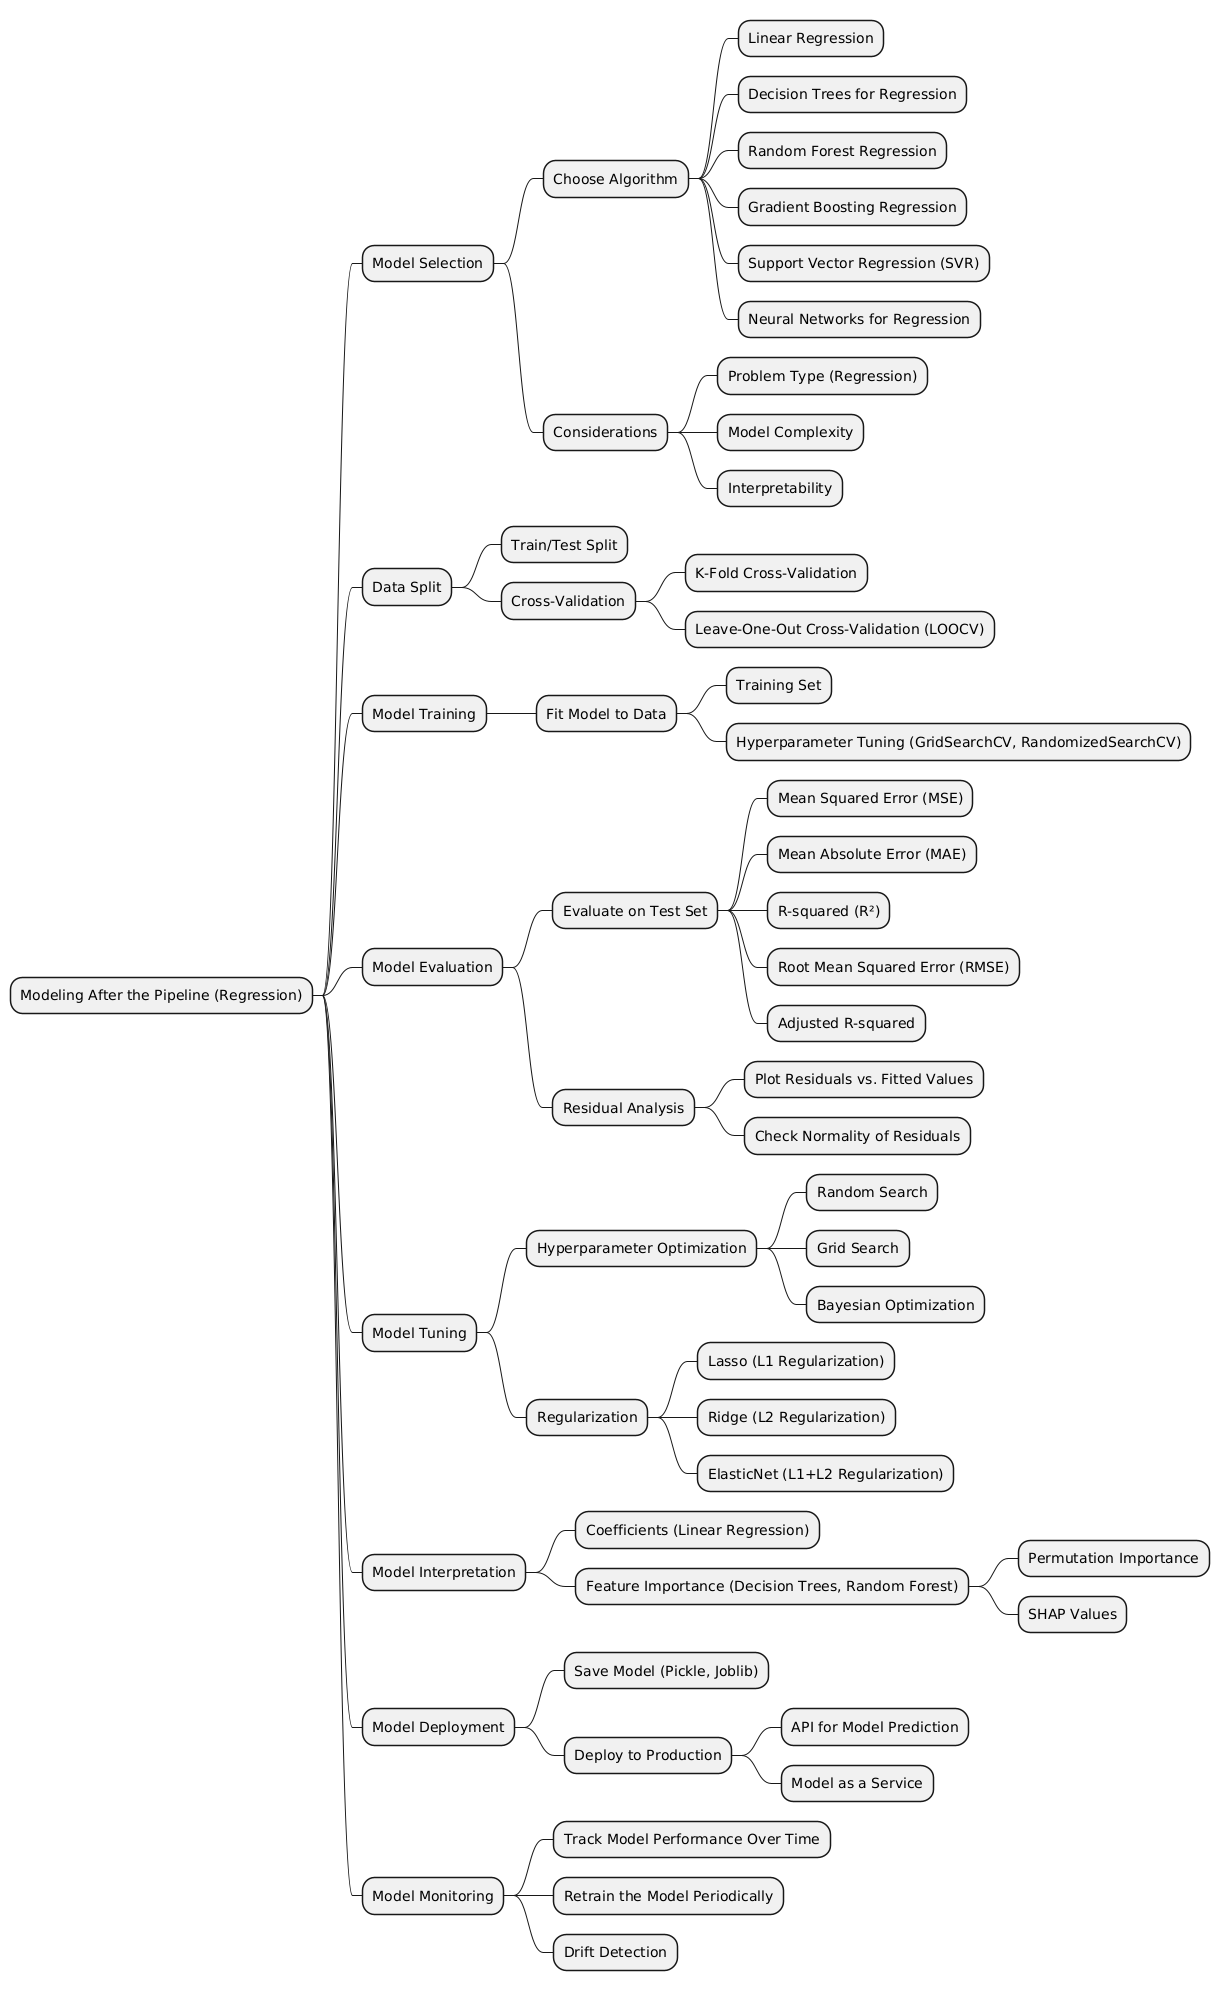
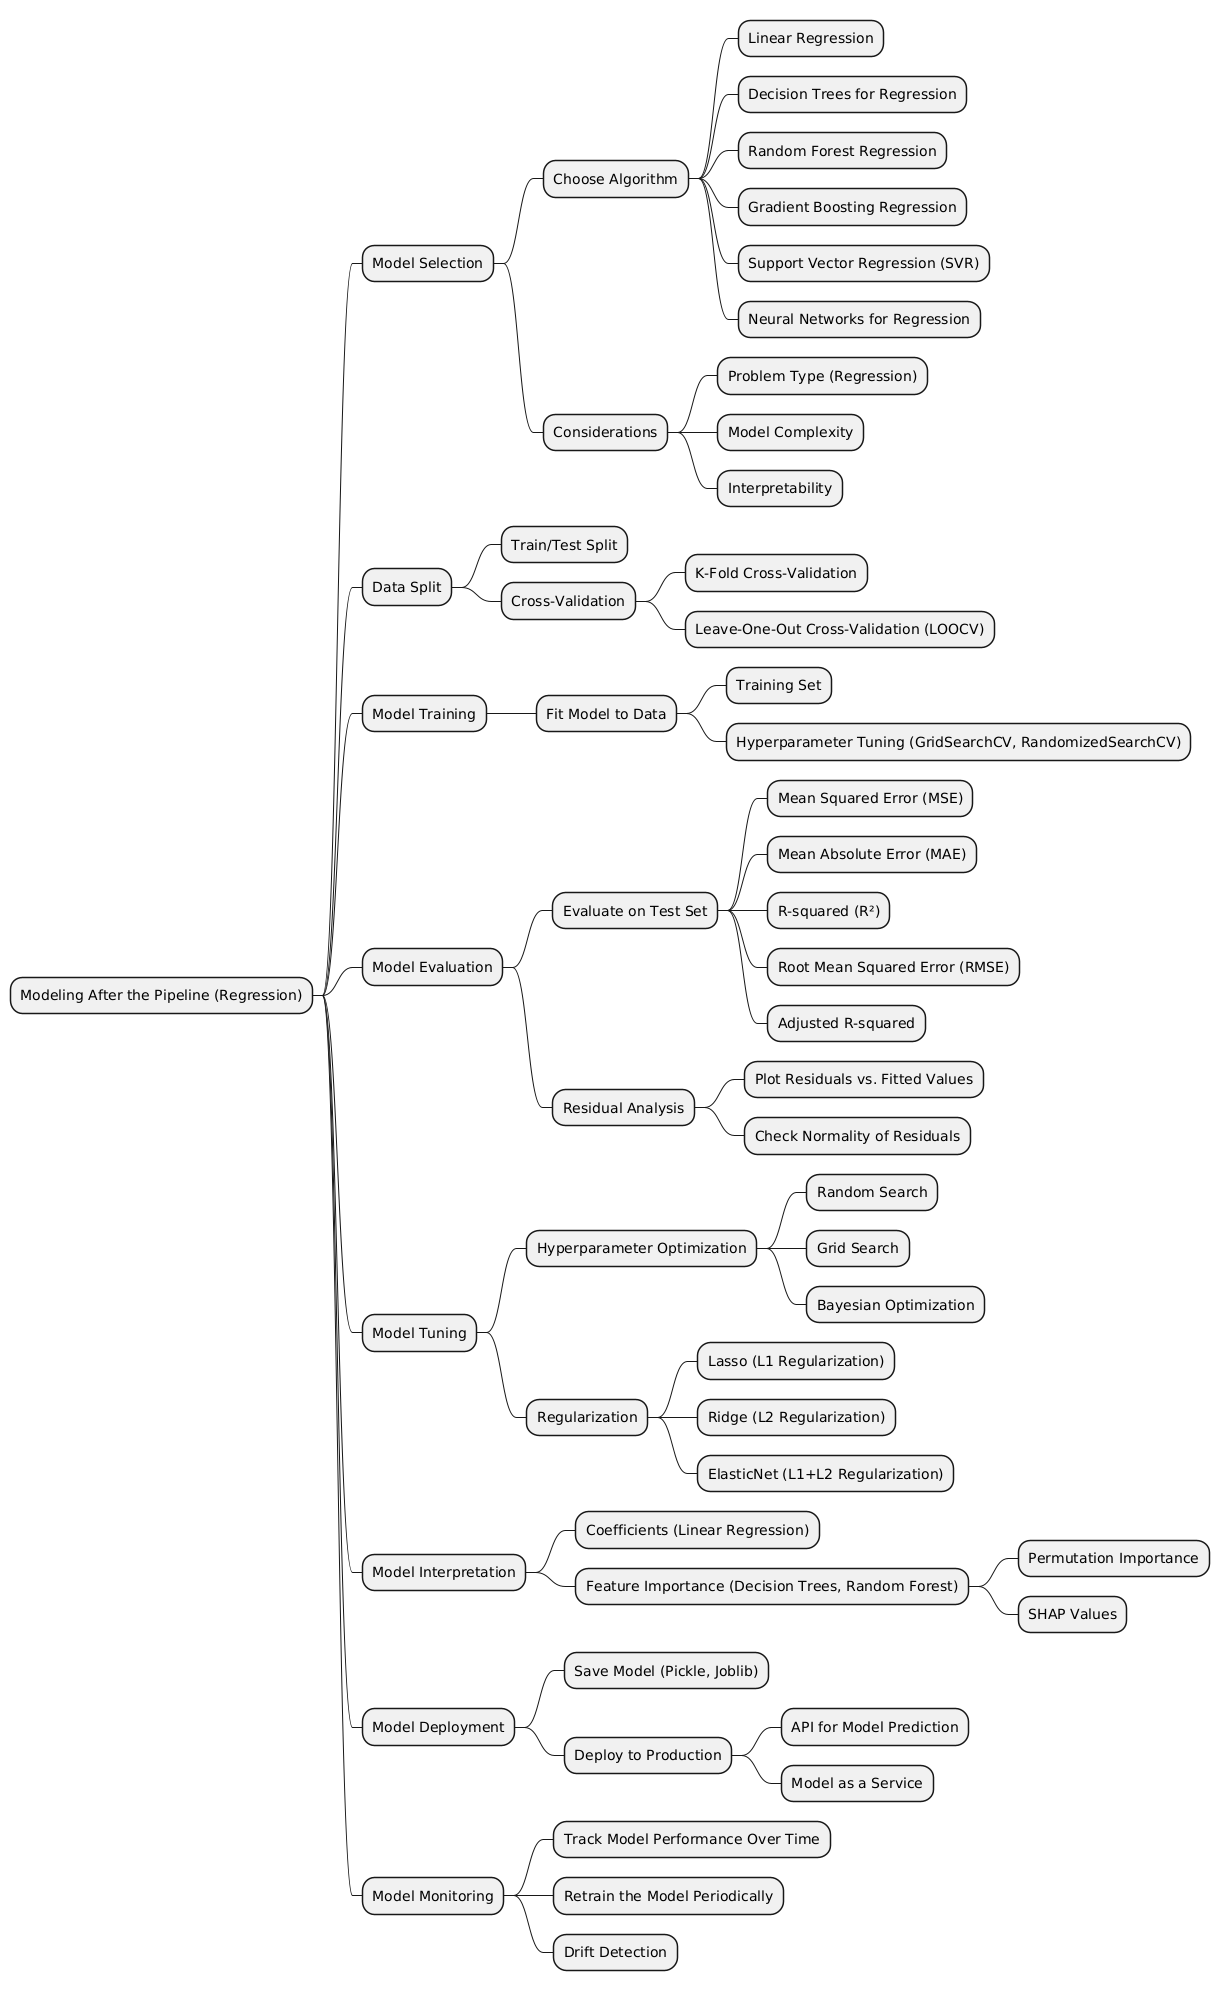

In [86]:
len(X_test)

240000

In [87]:
X = full[:train_size]
X_test = full[train_size:]

In [33]:
train = pl.read_csv("/kaggle/input/playground-series-s4e12/train.csv")
test = pl.read_csv("/kaggle/input/playground-series-s4e12/test.csv")
test_id = test["id"].to_numpy()
y = train["Premium Amount"]


Premium Amount
f64
2869.0
1483.0
567.0
765.0
2022.0
…
1303.0
821.0
371.0


In [34]:
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras import layers
# from tensorflow.keras.models import Model


# class TabNetAttention(layers.Layer):
#     def __init__(self, units=64):
#         super(TabNetAttention, self).__init__()
#         self.units = units
#         self.attention_weight = layers.Dense(units, activation='sigmoid', use_bias=False)
#         self.attention_output = layers.Dense(1, activation='sigmoid', use_bias=False)

#     def call(self, inputs):
#         attention_weights = self.attention_weight(inputs)
#         attention_output = self.attention_output(attention_weights)
#         return attention_output


# class TabNetBlock(layers.Layer):
#     def __init__(self, units=64):
#         super(TabNetBlock, self).__init__()
#         self.attention = TabNetAttention(units)
#         self.dense1 = layers.Dense(units, activation='relu')
#         self.dense2 = layers.Dense(units, activation='relu')
#         self.output_layer = layers.Dense(1)  

#     def call(self, inputs):
#         attention_output = self.attention(inputs)
#         x = self.dense1(inputs * attention_output)  
#         x = self.dense2(x)
#         return self.output_layer(x)

# # Crear el modelo TabNet
# class TabNetModel(Model):
#     def __init__(self, input_shape):
#         super(TabNetModel, self).__init__()
#         self.tabnet_block = TabNetBlock(units=64)

#     def call(self, inputs):
#         x = inputs  
#         return self.tabnet_block(x)


# # Dividir los datos en conjunto de entrenamiento y prueba
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Normalizar los datos de entrada
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# # Crear el modelo TabNet
# model = TabNetModel(input_shape=(X_train.shape[1],))  # El tamaño de la entrada debe coincidir con X_train

# # Compilar el modelo
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# # Entrenar el modelo
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# # Evaluar el modelo en el conjunto de prueba
# test_loss = model.evaluate(X_test, y_test)
# print(f"Test Loss: {test_loss}")

# works! without GPU

Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 1327382.3750 - val_loss: 770211.6875 - learning_rate: 0.0010
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 790918.1875 - val_loss: 747145.4375 - learning_rate: 0.0010
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 769047.8750 - val_loss: 734207.2500 - learning_rate: 0.0010
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 761454.7500 - val_loss: 732378.0000 - learning_rate: 0.0010
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 755544.3125 - val_loss: 732020.0000 - learning_rate: 0.0010
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 757672.1250 - val_loss: 731754.3750 - learning_rate: 0.0010
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 754744.4375 - val_loss: 731537.7500 - learning_rate: 0.0010
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 753672.0000 - val_loss: 731060.8125 - learning_rate: 0.0010
Epoch 9/50
750/750 ━━━━━━━━━━━━━━━━━━━━

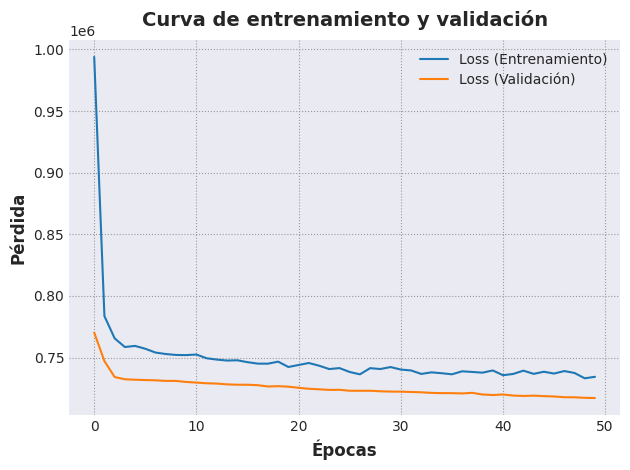

In [49]:
import polars as pl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Usar MirroredStrategy para distribuir el entrenamiento en múltiples GPUs
strategy = tf.distribute.MirroredStrategy()

# Obtener el número de características automáticamente
input_dim = X.shape[1]  # El número de columnas en X_train

# Crear el modelo dentro de la estrategia de distribución
with strategy.scope():
    # Crear el modelo secuencial
    model = Sequential()

    # Capa de entrada con el número de características automáticamente
    model.add(Dense(64, input_dim=input_dim, activation='relu'))  # input_dim automático
    model.add(Dropout(0.1))  # Dropout con tasa de 0.1

    # Capa oculta
    model.add(Dense(32, activation='elu'))
    model.add(Dropout(0.1))  # Dropout con tasa de 0.1

    # Capa oculta
    model.add(Dense(16, activation='elu'))

    # Capa de salida
    model.add(Dense(1))  # Para regresión, salida con 1 valor

    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Definir EarlyStopping para detener el entrenamiento si no mejora la validación
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Definir ReduceLROnPlateau para reducir la tasa de aprendizaje si la validación no mejora
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Entrenar el modelo y guardar el historial de entrenamiento
history = model.fit(X, y, epochs=50, batch_size=1280, validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr])

# Visualizar la curva de entrenamiento
plt.plot(history.history['loss'], label='Loss (Entrenamiento)')
plt.plot(history.history['val_loss'], label='Loss (Validación)')
plt.title('Curva de entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


In [ ]:
X = full[:train_size]
X_test = full[train_size:]

In [89]:
y_preds = model.predict(X_test)

25000/25000 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step


In [90]:
len(test_id)

800000

In [91]:
submis = pd.DataFrame()
submis["id"] = test_id
submis["Premium Amount"] = y_preds

In [94]:
submis.to_csv("Submission.csv")